In [1]:
import numpy as np
import glob
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from copy import copy
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
year = '2011-2012'
datadir = '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/'
landmaskfile = f'{datadir}mergir4km_grid_terrain_landmask.nc'
# landmaskfile = '/global/project/projectdirs/m1657/zfeng/usa/wrf/map_data/mergir4km_grid_terrain_landmask.nc'

# obsdir = '/global/project/projectdirs/m1657/zfeng/usa/nmq/stats/monthly/'
# obsfiles = [f'{obsdir}nmq_mcs_rainmap_2011.nc', f'{obsdir}nmq_mcs_rainmap_2012.nc']
obsfiles = [f'{datadir}nmq_mcs_rainmap_2011.nc', f'{datadir}nmq_mcs_rainmap_2012.nc']

# wrfdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/'
# wrf1files = [f'{wrfdir}wrf381_control_2011/statstb/monthly/wrf_irrig_mcs_rainmap_2011_regrid.nc',
#              f'{wrfdir}wrf381_control_2012/statstb/monthly/wrf_irrig_mcs_rainmap_2012_regrid.nc',]
# wrf2files = [f'{wrfdir}wrf381_irrig_2011/statstb/monthly/wrf_irrig_mcs_rainmap_2011_regrid.nc',
#              f'{wrfdir}wrf381_irrig_2012/statstb/monthly/wrf_irrig_mcs_rainmap_2012_regrid.nc',]
wrf1files = [f'{datadir}wrf_control_mcs_rainmap_2011_regrid.nc',
             f'{datadir}wrf_control_mcs_rainmap_2012_regrid.nc',]
wrf2files = [f'{datadir}wrf_irrig_mcs_rainmap_2011_regrid.nc',
             f'{datadir}wrf_irrig_mcs_rainmap_2012_regrid.nc',]

# wrf1stats = sorted(glob.glob(f'{wrfdir}wrf381_control_201?/statstb/robust_mcs_tracks_*.nc'))
# wrf2stats = sorted(glob.glob(f'{wrfdir}wrf381_irrig_201?/statstb/robust_mcs_tracks_*.nc'))
wrf1stats = sorted(glob.glob(f'{datadir}wrf_control_robust_mcs_tracks_*.nc'))
wrf2stats = sorted(glob.glob(f'{datadir}wrf_irrig_robust_mcs_tracks_*.nc'))

# Central US box
lonbox = [-105,-83]
latbox = [36,45]

# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/results/'
# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/figures4paper/'
figdir = datadir

In [3]:
wrf1stats, wrf2stats

(['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_control_robust_mcs_tracks_20110401_20111031.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_control_robust_mcs_tracks_20120401_20121031.nc'],
 ['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_irrig_robust_mcs_tracks_20110401_20111031.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_irrig_robust_mcs_tracks_20120401_20121031.nc'])

In [4]:
obsfiles, wrf1files, wrf2files

(['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/nmq_mcs_rainmap_2011.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/nmq_mcs_rainmap_2012.nc'],
 ['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_control_mcs_rainmap_2011_regrid.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_control_mcs_rainmap_2012_regrid.nc'],
 ['/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_irrig_mcs_rainmap_2011_regrid.nc',
  '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/wrf_irrig_mcs_rainmap_2012_regrid.nc'])

In [5]:
dsmap = xr.open_dataset(landmaskfile)
landmask = dsmap.LANDMASK

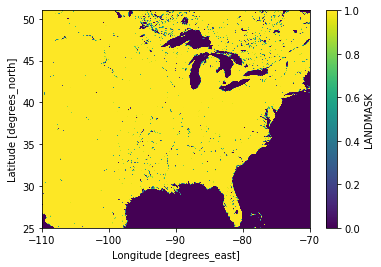

In [6]:
landmask.plot()

In [7]:
dsw1 = xr.open_mfdataset(wrf1stats, concat_dim='tracks', combine='nested')
# Replace tracks dimension so it monotonically increases
ntracks1 = dsw1.sizes['tracks']
tracks1 = np.arange(0, ntracks1, 1)
dsw1['tracks'] = tracks1
dsw1.load()

<xarray.Dataset>
Dimensions:                  (nlifecycle: 4, nmaxcore: 20, nmaxmerge: 80, nmaxpf: 10, nmaxpix: 150000, times: 120, tracks: 388)
Coordinates:
  * times                    (times) float32 0.0 1.0 2.0 ... 117.0 118.0 119.0
  * tracks                   (tracks) int64 0 1 2 3 4 5 ... 383 384 385 386 387
Dimensions without coordinates: nlifecycle, nmaxcore, nmaxmerge, nmaxpf, nmaxpix
Data variables:
    xtime                    (tracks, times) float32 0.0 1.0 2.0 ... 118.0 119.0
    length                   (tracks) float32 25.0 13.0 21.0 ... 41.0 39.0 39.0
    mcs_length               (tracks) float32 nan nan nan nan ... nan nan nan
    mcs_type                 (tracks) int16 1 1 1 1 1 1 2 1 ... 1 1 1 1 2 1 1 1
    starttrackresult         (tracks) float32 2.0 10.0 2.0 ... 2.0 10.0 13.0
    endtrackresult           (tracks) float32 0.0 12.0 0.0 0.0 ... 0.0 12.0 12.0
    base_time                (tracks, times) datetime64[ns] 2011-04-01T05:00:00 ... NaT
    julian_day       

In [8]:
dsw2 = xr.open_mfdataset(wrf2stats, concat_dim='tracks', combine='nested')
# Replace tracks dimension so it monotonically increases
ntracks2 = dsw2.sizes['tracks']
tracks2 = np.arange(0, ntracks2, 1)
dsw2['tracks'] = tracks2
dsw2.load()

<xarray.Dataset>
Dimensions:                  (nlifecycle: 4, nmaxcore: 20, nmaxmerge: 80, nmaxpf: 10, nmaxpix: 150000, times: 120, tracks: 398)
Coordinates:
  * times                    (times) float32 0.0 1.0 2.0 ... 117.0 118.0 119.0
  * tracks                   (tracks) int64 0 1 2 3 4 5 ... 393 394 395 396 397
Dimensions without coordinates: nlifecycle, nmaxcore, nmaxmerge, nmaxpf, nmaxpix
Data variables:
    xtime                    (tracks, times) float32 0.0 1.0 2.0 ... 118.0 119.0
    length                   (tracks) float32 25.0 13.0 13.0 ... 36.0 10.0 57.0
    mcs_length               (tracks) float32 nan nan nan nan ... nan nan nan
    mcs_type                 (tracks) int16 1 1 1 1 1 1 2 1 ... 2 1 1 1 1 1 1 1
    starttrackresult         (tracks) float32 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    endtrackresult           (tracks) float32 0.0 0.0 0.0 12.0 ... 0.0 12.0 0.0
    base_time                (tracks, times) datetime64[ns] 2011-04-01T05:00:00 ... NaT
    julian_day       

In [9]:
def get_lifestage_hour(ntracks, basetime, lifeindex):
    """ Get the first hour for specific lifecycle stage
    """ 
    hourconvinit = np.zeros(ntracks) * np.nan
    hourgenesis = np.zeros(ntracks) * np.nan
    hourmature = np.zeros(ntracks) * np.nan

    # Loop over each MCS track
    for it in range(ntracks):
        ibt = basetime.values[it,:]
        idxconvinit = lifeindex.values[it,0]
        idxgenesis = lifeindex.values[it,1]
        idxmature = lifeindex.values[it,2]

        if (np.isfinite(idxconvinit) == True):
            hourconvinit[it] = ibt[idxconvinit.astype(int)].astype('datetime64[s]').astype(object).hour
        if (np.isfinite(idxgenesis) == True):
            hourgenesis[it] = ibt[idxgenesis.astype(int)].astype('datetime64[s]').astype(object).hour
        if (np.isfinite(idxmature) == True):
            hourmature[it] = ibt[idxmature.astype(int)].astype('datetime64[s]').astype(object).hour
    
    return hourconvinit, hourgenesis, hourmature

In [10]:
def get_lifestage_location(ntracks, pf_lon, pf_lat, lifeindex):
    """ Get the first hour for specific lifecycle stage
    """ 
    lonconvinit = np.zeros(ntracks) * np.nan
    latconvinit = np.zeros(ntracks) * np.nan
    longenesis = np.zeros(ntracks) * np.nan
    latgenesis = np.zeros(ntracks) * np.nan
    lonmature = np.zeros(ntracks) * np.nan
    latmature = np.zeros(ntracks) * np.nan

    # Loop over each MCS track
    for it in range(ntracks):
        ilon = pf_lon.values[it,:]
        ilat = pf_lat.values[it,:]
        idxconvinit = lifeindex.values[it,0]
        idxgenesis = lifeindex.values[it,1]
        idxmature = lifeindex.values[it,2]

        if (np.isfinite(idxconvinit) == True):
            lonconvinit[it] = ilon[idxconvinit.astype(int)]
            latconvinit[it] = ilat[idxconvinit.astype(int)]
        if (np.isfinite(idxgenesis) == True):
            longenesis[it] = ilon[idxgenesis.astype(int)]
            latgenesis[it] = ilat[idxgenesis.astype(int)]
        if (np.isfinite(idxmature) == True):
            lonmature[it] = ilon[idxmature.astype(int)]
            latmature[it] = ilat[idxmature.astype(int)]
    
    return lonconvinit, latconvinit, longenesis, latgenesis, lonmature, latmature

In [11]:
starttime_w1 = dsw1.base_time.isel(times=0)
sseason_w1 = starttime_w1.dt.season
shour_w1 = starttime_w1.dt.hour

# Select tracks in JJA
mcsidx_w1 = np.where(sseason_w1 == 'JJA')[0]
nmcs_w1 = np.count_nonzero(mcsidx_w1)
basetime_w1 = dsw1.base_time.isel(tracks=mcsidx_w1)
pflon_w1 = dsw1.pf_lon.isel(tracks=mcsidx_w1, nmaxpf=0)
pflat_w1 = dsw1.pf_lat.isel(tracks=mcsidx_w1, nmaxpf=0)
lifeindex_w1 = dsw1.lifecycle_index.isel(tracks=mcsidx_w1)

In [12]:
starttime_w2 = dsw2.base_time.isel(times=0)
sseason_w2 = starttime_w2.dt.season
shour_w2 = starttime_w2.dt.hour

# Select tracks in JJA
mcsidx_w2 = np.where(sseason_w2 == 'JJA')[0]
nmcs_w2 = np.count_nonzero(mcsidx_w2)
basetime_w2 = dsw2.base_time.isel(tracks=mcsidx_w2)
pflon_w2 = dsw2.pf_lon.isel(tracks=mcsidx_w2, nmaxpf=0)
pflat_w2 = dsw2.pf_lat.isel(tracks=mcsidx_w2, nmaxpf=0)
lifeindex_w2 = dsw2.lifecycle_index.isel(tracks=mcsidx_w2)

# Get time and location of 3 key stages of MCSs

In [13]:
hourconvinit_w1, hourgenesis_w1, hourmature_w1 = get_lifestage_hour(nmcs_w1, basetime_w1, lifeindex_w1)
lonconvinit_w1, latconvinit_w1, longenesis_w1, latgenesis_w1, lonmature_w1, latmature_w1 = get_lifestage_location(nmcs_w1, pflon_w1, pflat_w1, lifeindex_w1)

In [14]:
hourconvinit_w2, hourgenesis_w2, hourmature_w2 = get_lifestage_hour(nmcs_w2, basetime_w2, lifeindex_w2)
lonconvinit_w2, latconvinit_w2, longenesis_w2, latgenesis_w2, lonmature_w2, latmature_w2 = get_lifestage_location(nmcs_w2, pflon_w2, pflat_w2, lifeindex_w2)

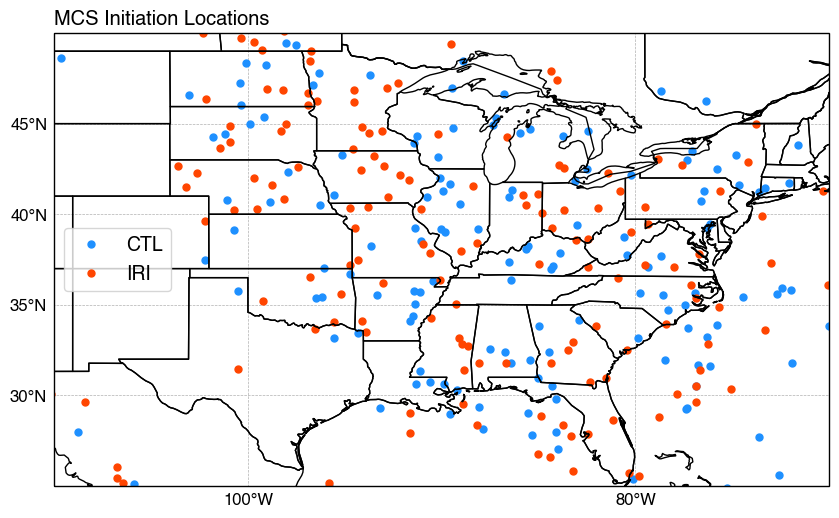

In [15]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'

map_extend = [-110, -70, 25., 50.]
lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,20))
latvals = mpl.ticker.FixedLocator(np.arange(-90,90.1,5))
levelshgt = [1000,2000]

fig = plt.figure(figsize=[10,6], dpi=100)

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)

# gs = gridspec.GridSpec(2,2, height_ratios=[0.4,0.4], width_ratios=[1,0.02])
# gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.05, hspace=0.2)

# Panel 1
# ax1 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
ax1 = plt.subplot(projection=ccrs.PlateCarree())
ax1.set_extent(map_extend, crs=ccrs.PlateCarree())
# ax1.add_feature(land, facecolor='lightgray')
#     ax1.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
ax1.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=4)
ax1.add_feature(states, edgecolor='k', facecolor='none', linewidth=1, zorder=4)
ax1.add_feature(land, facecolor='none', edgecolor='k', zorder=2)
ax1.set_aspect('auto', adjustable=None)
ax1.set_title('MCS Initiation Locations', loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax1.plot(lonconvinit_w1, latconvinit_w1, 'o', color='dodgerblue', markersize=5, transform=ccrs.PlateCarree(), label='CTL')
# ax1.plot(lonconvinit_w2, latconvinit_w2, 'o', color='orangered', markersize=5, transform=ccrs.PlateCarree(), label='IRI')
ax1.plot(longenesis_w1, latgenesis_w1, 'o', color='dodgerblue', markersize=5, transform=ccrs.PlateCarree(), label='CTL')
ax1.plot(longenesis_w2, latgenesis_w2, 'o', color='orangered', markersize=5, transform=ccrs.PlateCarree(), label='IRI')
ax1.legend(fontsize=14)

fig.savefig(f'{figdir}mcs_initiation_location_map.png', dpi=300, bbox_inches='tight')

In [16]:
dsobs = xr.open_mfdataset(obsfiles, concat_dim='time', combine='nested')
# dateobs = pd.date_range(start='2011-04-01', end='2011-10-31', freq='MS')
# dsobs['time'] = dateobs
dsobs.load()

<xarray.Dataset>
Dimensions:                  (lat: 715, lon: 1100, time: 14)
Coordinates:
  * lat                      (lat) float32 25.015163 25.051548 ... 50.99454
  * lon                      (lon) float32 -109.98989 -109.953514 ... -70.0101
  * time                     (time) datetime64[ns] 2011-04-01 ... 2012-10-01
Data variables:
    precipitation            (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ntimes                   (time) int32 718 744 720 741 ... 743 743 710 737
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Mar 28 17:17:54 2018

In [17]:
dswrf1 = xr.open_mfdataset(wrf1files, concat_dim='time', combine='nested')
date11 = pd.date_range(start=f'2011-04-01', end=f'2011-10-31', freq='MS')
date12 = pd.date_range(start=f'2012-04-01', end=f'2012-10-31', freq='MS')
datewrf1 = date11.union(date12)
dswrf1['time'] = datewrf1
dswrf1.load()

<xarray.Dataset>
Dimensions:                  (lat: 715, lon: 1100, nbnd: 2, time: 14)
Coordinates:
  * lat                      (lat) float64 25.02 25.05 25.09 ... 50.96 50.99
  * lon                      (lon) float64 -110.0 -110.0 ... -70.05 -70.01
  * time                     (time) datetime64[ns] 2011-04-01 ... 2012-10-01
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds                 (time, lat, nbnd) float64 25.0 25.03 ... 51.01
    lon_bnds                 (time, lon, nbnd) float64 -110.0 -110.0 ... -69.99
    gw                       (time, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                     (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... nan nan
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... nan nan
    ntimes                   (time) int32 719 744 720 744 ... 744 744 720 744
    precipitation            (time, lat, lon) float32 0.08592185 ... 

In [18]:
dswrf2 = xr.open_mfdataset(wrf2files, concat_dim='time', combine='nested')
# datewrf2 = pd.date_range(start=f'{year}-04-01', end=f'{year}-10-31', freq='MS')
dswrf2['time'] = datewrf1
dswrf2.load()

<xarray.Dataset>
Dimensions:                  (lat: 715, lon: 1100, nbnd: 2, time: 14)
Coordinates:
  * lat                      (lat) float64 25.02 25.05 25.09 ... 50.96 50.99
  * lon                      (lon) float64 -110.0 -110.0 ... -70.05 -70.01
  * time                     (time) datetime64[ns] 2011-04-01 ... 2012-10-01
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds                 (time, lat, nbnd) float64 25.0 25.03 ... 51.01
    lon_bnds                 (time, lon, nbnd) float64 -110.0 -110.0 ... -69.99
    gw                       (time, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                     (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... nan nan
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... nan nan
    ntimes                   (time) int32 719 744 720 744 ... 744 744 720 744
    precipitation            (time, lat, lon) float32 0.1826243 ... n

In [19]:
# dswrf1.mcs_precipitation.sel(time=f'2012-06-01').plot(vmax=200)

In [20]:
# dswrf2.mcs_precipitation.sel(time=f'2012-06-01').plot(vmax=200)

In [21]:
# The regridded WRF file lat/lon maybe just slightly different from OBS due to precision issue in netcdf file
# To avoid issue when subtracting WRF with OBS, replace lat/lon in OBS with WRF lat/lon so that they are consistent
dsobs['lat'] = dswrf1['lat']
dsobs['lon'] = dswrf1['lon']
lon = dsobs.lon
lat = dsobs.lat

In [22]:
months_obs = dsobs.time.dt.month
months_obs

<xarray.DataArray 'month' (time: 14)>
array([ 4,  5,  6,  7,  8,  9, 10,  4,  5,  6,  7,  8,  9, 10])
Coordinates:
  * time     (time) datetime64[ns] 2011-04-01 2011-05-01 ... 2012-10-01

In [23]:
months_wrf1 = dswrf1.time.dt.month
months_wrf2 = dswrf2.time.dt.month

In [24]:
# Total number of hours
nhours_mam_obs = dsobs.ntimes.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time').values
nhours_jja_obs = dsobs.ntimes.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time').values
nhours_son_obs = dsobs.ntimes.where((months_obs >= 9) & (months_obs <= 11)).sum(dim='time').values

# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_mam_obs = 24. * dsobs.precipitation.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time') / nhours_mam_obs
totpcp_jja_obs = 24. * dsobs.precipitation.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time') / nhours_jja_obs
totpcp_son_obs = 24. * dsobs.precipitation.where((months_obs >= 9) & (months_obs <= 11)).sum(dim='time') / nhours_son_obs

mcspcp_mam_obs = 24. * dsobs.mcs_precipitation.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time') / nhours_mam_obs
mcspcp_jja_obs = 24. * dsobs.mcs_precipitation.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time') / nhours_jja_obs
mcspcp_son_obs = 24. * dsobs.mcs_precipitation.where((months_obs >= 9) & (months_obs <= 11)).sum(dim='time') / nhours_son_obs

totpcpsum_mam_obs = dsobs.precipitation.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time')
totpcpsum_jja_obs = dsobs.precipitation.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time')
totpcpsum_son_obs = dsobs.precipitation.where((months_obs >= 9) & (months_obs <= 11)).sum(dim='time')

mcspcpsum_mam_obs = dsobs.mcs_precipitation.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time')
mcspcpsum_jja_obs = dsobs.mcs_precipitation.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time')
mcspcpsum_son_obs = dsobs.mcs_precipitation.where((months_obs >= 9) & (months_obs <= 11)).sum(dim='time')

# MCS precipitation fraction
mcspcpfrac_mam_obs = 100 * mcspcpsum_mam_obs / totpcpsum_mam_obs
mcspcpfrac_jja_obs = 100 * mcspcpsum_jja_obs / totpcpsum_jja_obs
mcspcpfrac_son_obs = 100 * mcspcpsum_son_obs / totpcpsum_son_obs
# mcspcpfrac_mam_obs = 100 * mcspcp_mam_obs / totpcp_mam_obs
# mcspcpfrac_jja_obs = 100 * mcspcp_jja_obs / totpcp_jja_obs
# mcspcpfrac_son_obs = 100 * mcspcp_son_obs / totpcp_son_obs

# MCS precipitation frequency
mcspcpfreq_mam_obs = 100 * dsobs.mcs_precipitation_count.where((months_obs >= 3) & (months_obs <= 5)).sum(dim='time') / nhours_mam_obs
mcspcpfreq_jja_obs = 100 * dsobs.mcs_precipitation_count.where((months_obs >= 6) & (months_obs <= 8)).sum(dim='time') / nhours_jja_obs
mcspcpfreq_son_obs = 100 * dsobs.mcs_precipitation_count.where((months_obs >= 9) & (months_obs <= 10)).sum(dim='time') / nhours_son_obs

In [25]:
# mcspcpsum_jja_obs.plot(vmax=400)

In [26]:
# mcspcpfrac_jja_obs.plot(vmax=80, cmap='Spectral_r')

In [27]:
# Total number of hours
nhours_mam_wrf1 = dswrf1.ntimes.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time').values
nhours_jja_wrf1 = dswrf1.ntimes.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time').values
nhours_son_wrf1 = dswrf1.ntimes.where((months_wrf1 >= 9) & (months_wrf1 <= 11)).sum(dim='time').values

# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_mam_wrf1 = 24. * dswrf1.precipitation.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time') / nhours_mam_wrf1
totpcp_jja_wrf1 = 24. * dswrf1.precipitation.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time') / nhours_jja_wrf1
totpcp_son_wrf1 = 24. * dswrf1.precipitation.where((months_wrf1 >= 9) & (months_wrf1 <= 11)).sum(dim='time') / nhours_son_wrf1

mcspcp_mam_wrf1 = 24. * dswrf1.mcs_precipitation.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time') / nhours_mam_wrf1
mcspcp_jja_wrf1 = 24. * dswrf1.mcs_precipitation.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time') / nhours_jja_wrf1
mcspcp_son_wrf1 = 24. * dswrf1.mcs_precipitation.where((months_wrf1 >= 9) & (months_wrf1 <= 11)).sum(dim='time') / nhours_son_wrf1

totpcpsum_mam_wrf1 = dswrf1.precipitation.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time')
totpcpsum_jja_wrf1 = dswrf1.precipitation.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time')
totpcpsum_son_wrf1 = dswrf1.precipitation.where((months_wrf1 >= 9) & (months_wrf1 <= 11)).sum(dim='time')

mcspcpsum_mam_wrf1 = dswrf1.mcs_precipitation.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time')
mcspcpsum_jja_wrf1 = dswrf1.mcs_precipitation.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time')
mcspcpsum_son_wrf1 = dswrf1.mcs_precipitation.where((months_wrf1 >= 9) & (months_wrf1 <= 11)).sum(dim='time')

# MCS precipitation fraction
mcspcpfrac_mam_wrf1 = 100 * mcspcpsum_mam_wrf1 / totpcpsum_mam_wrf1
mcspcpfrac_jja_wrf1 = 100 * mcspcpsum_jja_wrf1 / totpcpsum_jja_wrf1
mcspcpfrac_son_wrf1 = 100 * mcspcpsum_son_wrf1 / totpcpsum_son_wrf1
# mcspcpfrac_mam_wrf1 = 100 * mcspcp_mam_wrf1 / totpcp_mam_wrf1
# mcspcpfrac_jja_wrf1 = 100 * mcspcp_jja_wrf1 / totpcp_jja_wrf1
# mcspcpfrac_son_wrf1 = 100 * mcspcp_son_wrf1 / totpcp_son_wrf1

# MCS precipitation frequency
mcspcpfreq_mam_wrf1 = 100 * dswrf1.mcs_precipitation_count.where((months_wrf1 >= 3) & (months_wrf1 <= 5)).sum(dim='time') / nhours_mam_wrf1
mcspcpfreq_jja_wrf1 = 100 * dswrf1.mcs_precipitation_count.where((months_wrf1 >= 6) & (months_wrf1 <= 8)).sum(dim='time') / nhours_jja_wrf1
mcspcpfreq_son_wrf1 = 100 * dswrf1.mcs_precipitation_count.where((months_wrf1 >= 9) & (months_wrf1 <= 10)).sum(dim='time') / nhours_son_wrf1

In [28]:
# Total number of hours
nhours_mam_wrf2 = dswrf2.ntimes.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time').values
nhours_jja_wrf2 = dswrf2.ntimes.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time').values
nhours_son_wrf2 = dswrf2.ntimes.where((months_wrf2 >= 9) & (months_wrf2 <= 11)).sum(dim='time').values

# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_mam_wrf2 = 24. * dswrf2.precipitation.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time') / nhours_mam_wrf2
totpcp_jja_wrf2 = 24. * dswrf2.precipitation.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time') / nhours_jja_wrf2
totpcp_son_wrf2 = 24. * dswrf2.precipitation.where((months_wrf2 >= 9) & (months_wrf2 <= 11)).sum(dim='time') / nhours_son_wrf2

mcspcp_mam_wrf2 = 24. * dswrf2.mcs_precipitation.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time') / nhours_mam_wrf2
mcspcp_jja_wrf2 = 24. * dswrf2.mcs_precipitation.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time') / nhours_jja_wrf2
mcspcp_son_wrf2 = 24. * dswrf2.mcs_precipitation.where((months_wrf2 >= 9) & (months_wrf2 <= 11)).sum(dim='time') / nhours_son_wrf2

totpcpsum_mam_wrf2 = dswrf2.precipitation.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time')
totpcpsum_jja_wrf2 = dswrf2.precipitation.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time')
totpcpsum_son_wrf2 = dswrf2.precipitation.where((months_wrf2 >= 9) & (months_wrf2 <= 11)).sum(dim='time')

mcspcpsum_mam_wrf2 = dswrf2.mcs_precipitation.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time')
mcspcpsum_jja_wrf2 = dswrf2.mcs_precipitation.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time')
mcspcpsum_son_wrf2 = dswrf2.mcs_precipitation.where((months_wrf2 >= 9) & (months_wrf2 <= 11)).sum(dim='time')

# MCS precipitation fraction
mcspcpfrac_mam_wrf2 = 100 * mcspcpsum_mam_wrf2 / totpcpsum_mam_wrf2
mcspcpfrac_jja_wrf2 = 100 * mcspcpsum_jja_wrf2 / totpcpsum_jja_wrf2
mcspcpfrac_son_wrf2 = 100 * mcspcpsum_son_wrf2 / totpcpsum_son_wrf2
# mcspcpfrac_mam_wrf2 = 100 * mcspcp_mam_wrf2 / totpcp_mam_wrf2
# mcspcpfrac_jja_wrf2 = 100 * mcspcp_jja_wrf2 / totpcp_jja_wrf2
# mcspcpfrac_son_wrf2 = 100 * mcspcp_son_wrf2 / totpcp_son_wrf2

# MCS precipitation frequency
mcspcpfreq_mam_wrf2 = 100 * dswrf2.mcs_precipitation_count.where((months_wrf2 >= 3) & (months_wrf2 <= 5)).sum(dim='time') / nhours_mam_wrf2
mcspcpfreq_jja_wrf2 = 100 * dswrf2.mcs_precipitation_count.where((months_wrf2 >= 6) & (months_wrf2 <= 8)).sum(dim='time') / nhours_jja_wrf2
mcspcpfreq_son_wrf2 = 100 * dswrf2.mcs_precipitation_count.where((months_wrf2 >= 9) & (months_wrf2 <= 10)).sum(dim='time') / nhours_son_wrf2

In [29]:
totpcp_mam_wrf21 = totpcp_mam_wrf2 - totpcp_mam_wrf1
totpcp_jja_wrf21 = totpcp_jja_wrf2 - totpcp_jja_wrf1
totpcp_son_wrf21 = totpcp_son_wrf2 - totpcp_son_wrf1

mcspcp_mam_wrf21 = mcspcp_mam_wrf2 - mcspcp_mam_wrf1
mcspcp_jja_wrf21 = mcspcp_jja_wrf2 - mcspcp_jja_wrf1
mcspcp_son_wrf21 = mcspcp_son_wrf2 - mcspcp_son_wrf1

mcspcpsum_mam_wrf21 = mcspcpsum_mam_wrf2 - mcspcpsum_mam_wrf1
mcspcpsum_jja_wrf21 = mcspcpsum_jja_wrf2 - mcspcpsum_jja_wrf1
mcspcpsum_son_wrf21 = mcspcpsum_son_wrf2 - mcspcpsum_son_wrf1

totpcpsum_mam_wrf21 = totpcpsum_mam_wrf2 - totpcpsum_mam_wrf1
totpcpsum_jja_wrf21 = totpcpsum_jja_wrf2 - totpcpsum_jja_wrf1
totpcpsum_son_wrf21 = totpcpsum_son_wrf2 - totpcpsum_son_wrf1

mcspcpfreq_mam_wrf21 = mcspcpfreq_mam_wrf2 - mcspcpfreq_mam_wrf1
mcspcpfreq_jja_wrf21 = mcspcpfreq_jja_wrf2 - mcspcpfreq_jja_wrf1
mcspcpfreq_son_wrf21 = mcspcpfreq_son_wrf2 - mcspcpfreq_son_wrf1

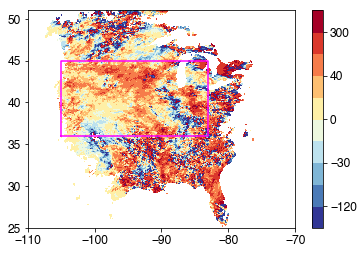

In [30]:
mcspcp_jja_wrfobs_percent = 100 * ((mcspcp_jja_wrf2 - mcspcp_jja_wrf1) / (mcspcp_jja_obs - mcspcp_jja_wrf1))
levels = [-200,-120,-60,-30,-10,0,20,40,100,300,600]
cmap = plt.get_cmap('RdYlBu_r')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
Zm = mcspcp_jja_wrfobs_percent.where((mcspcpfreq_jja_obs > 0.3) & (landmask == 1))
plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap)
plt.plot([lonbox[0],lonbox[1],lonbox[1],lonbox[0],lonbox[0]], [latbox[0],latbox[0],latbox[1],latbox[1],latbox[0]], color='magenta')
plt.colorbar()

In [31]:
bins_wrfobs = np.arange(-200,301,10)
pdf_mcspcp_jja_wrfobs_percent, bins = np.histogram(mcspcp_jja_wrfobs_percent.sel(lon=slice(lonbox[0],lonbox[1]), lat=slice(latbox[0],latbox[1])), \
                                                   bins=bins_wrfobs, density=True)
w2_avg = (mcspcp_jja_wrf2).where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
w1_avg = (mcspcp_jja_wrf1).where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
o_avg = mcspcp_jja_obs.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
pdf_mcspcp_jja_wrfobs_cus_avg_percent = 100 * ((w2_avg - w1_avg) / (o_avg - w1_avg)).values
print(f'JJA MCS precipitation bias improvement (CUS): {pdf_mcspcp_jja_wrfobs_cus_avg_percent:.0f}%')

JJA MCS precipitation bias improvement (CUS): 25%


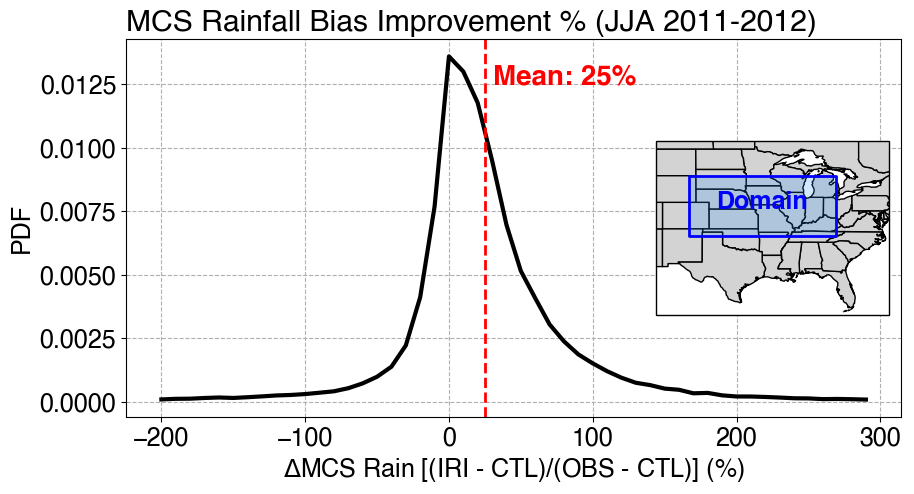

In [32]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[10,5], dpi=100)
ax = plt.subplot(111)
ax.plot(bins_wrfobs[:-1], pdf_mcspcp_jja_wrfobs_percent, color='k', lw=3)
ax.axvline(pdf_mcspcp_jja_wrfobs_cus_avg_percent, color='r', ls='--', lw=2)
ax.grid(ls='--')
ax.set_xlabel('$\Delta$MCS Rain [(IRI - CTL)/(OBS - CTL)] (%)')
ax.set_ylabel('PDF')
ax.set_title(f'MCS Rainfall Bias Improvement % (JJA {year})', loc='left')
ax.text(pdf_mcspcp_jja_wrfobs_cus_avg_percent+5, 0.0125, f'Mean: {pdf_mcspcp_jja_wrfobs_cus_avg_percent:.0f}%', color='r', fontsize=20, weight='bold')

proj = ccrs.PlateCarree()
axins = inset_axes(ax, width="30%", height="50%", loc="center right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=0.5, 
                   axes_kwargs=dict(map_projection=proj))
axins.set_extent([-110, -75, 24, 49], ccrs.Geodetic())
# axins.set_extent([-113, -80, 22, 46], proj)
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
# axins.background_patch.set_visible(False)
# axins.outline_patch.set_visible(False)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')
axins.add_feature(states, linewidth=1, edgecolor='k', facecolor='lightgray')
# lon_d2 = [-110.9,-83.2]
# lat_d2 = [27.9,45.1]
box_avg = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
axins.add_geometries([box_avg], proj, facecolor='dodgerblue', edgecolor='none', alpha=0.2, zorder=6)
axins.add_geometries([box_avg], proj, facecolor='none', edgecolor='b', lw=2, zorder=6)
axins.text(-94, 40, 'Domain', color='b', fontsize=18, fontweight='bold', ha='center', zorder=10)

fig.savefig(f'{figdir}mcs_rainbias_improvement_cus_pdf.png', dpi=300, bbox_inches='tight')

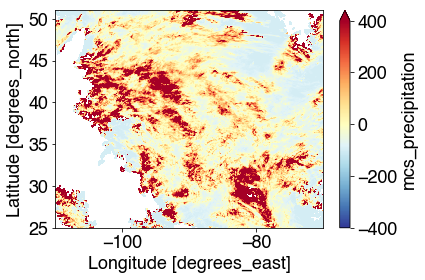

In [33]:
mcspcp_jja_wrf21_percent = 100 * (mcspcp_jja_wrf2 - mcspcp_jja_wrf1) / mcspcp_jja_wrf1
mcspcp_jja_wrf21_percent.plot(vmin=-400, vmax=400, cmap='RdYlBu_r')

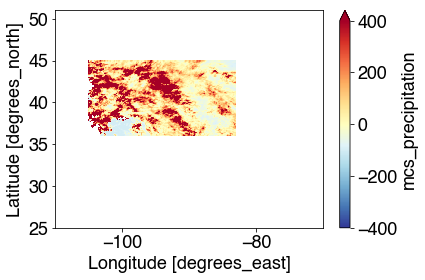

In [34]:
mcspcp_jja_wrf21_percent.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1])).plot(vmin=-400, vmax=400, cmap='RdYlBu_r')

In [35]:
mcspcp_jja_wrf1_cus_avg = mcspcp_jja_wrf1.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
mcspcp_jja_wrf2_cus_avg = mcspcp_jja_wrf2.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
mcspcp_jja_wrf21_cus_avg_percent = 100 * ((mcspcp_jja_wrf2_cus_avg - mcspcp_jja_wrf1_cus_avg) / mcspcp_jja_wrf1_cus_avg).values
print(f'JJA MCS precipitation mean diff (CUS): {mcspcp_jja_wrf21_cus_avg_percent:.0f}%')

JJA MCS precipitation mean diff (CUS): 65%


In [36]:
mcspcp_mam_wrf1obs = mcspcp_mam_wrf1 - mcspcp_mam_obs
mcspcp_jja_wrf1obs = mcspcp_jja_wrf1 - mcspcp_jja_obs
mcspcp_son_wrf1obs = mcspcp_son_wrf1 - mcspcp_son_obs

mcspcpfreq_mam_wrf1obs = mcspcpfreq_mam_wrf1 - mcspcpfreq_mam_obs
mcspcpfreq_jja_wrf1obs = mcspcpfreq_jja_wrf1 - mcspcpfreq_jja_obs
mcspcpfreq_son_wrf1obs = mcspcpfreq_son_wrf1 - mcspcpfreq_son_obs

In [37]:
mcspcp_mam_wrf2obs = mcspcp_mam_wrf2 - mcspcp_mam_obs
mcspcp_jja_wrf2obs = mcspcp_jja_wrf2 - mcspcp_jja_obs
mcspcp_son_wrf2obs = mcspcp_son_wrf2 - mcspcp_son_obs

mcspcpfreq_mam_wrf2obs = mcspcpfreq_mam_wrf2 - mcspcpfreq_mam_obs
mcspcpfreq_jja_wrf2obs = mcspcpfreq_jja_wrf2 - mcspcpfreq_jja_obs
mcspcpfreq_son_wrf2obs = mcspcpfreq_son_wrf2 - mcspcpfreq_son_obs

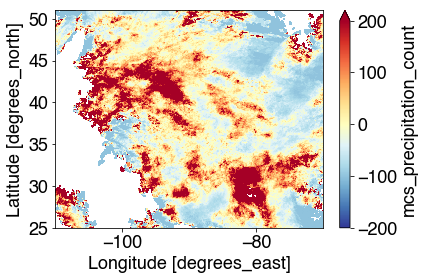

In [38]:
mcspcpfreq_jja_wrf21_percent = (100 * (mcspcpfreq_jja_wrf2 - mcspcpfreq_jja_wrf1) / mcspcpfreq_jja_wrf1)
mcspcpfreq_jja_wrf21_percent.plot(vmin=-200, vmax=200, cmap='RdYlBu_r')

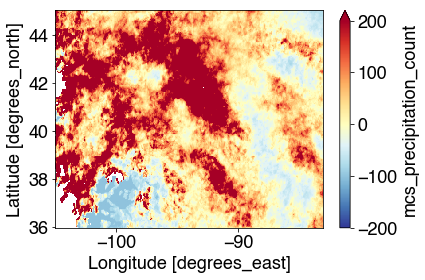

In [39]:
mcspcpfreq_jja_wrf21_percent.sel(lon=slice(lonbox[0],lonbox[1]), lat=slice(latbox[0],latbox[1])).plot(vmin=-200, vmax=200, cmap='RdYlBu_r')

In [40]:
mcspcpfreq_wrf21_percent_cus = mcspcpfreq_jja_wrf21_percent.sel(lon=slice(lonbox[0],lonbox[1]), lat=slice(latbox[0],latbox[1]))
np.ma.masked_invalid(mcspcpfreq_wrf21_percent_cus).mean()

251.2109677507628

In [41]:
mcspcpfreq_jja_wrf1_cus_avg = mcspcpfreq_jja_wrf1.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
mcspcpfreq_jja_wrf2_cus_avg = mcspcpfreq_jja_wrf2.where((lon >= lonbox[0]) & (lon <= lonbox[1]) & (lat >= latbox[0]) & (lat <= latbox[1]), drop='True').mean()
mcspcpfreq_jja_wrf21_cus_avg_percent = 100 * ((mcspcpfreq_jja_wrf2_cus_avg - mcspcpfreq_jja_wrf1_cus_avg) / mcspcpfreq_jja_wrf1_cus_avg).values
print(f'JJA MCS precipitation freq mean diff (CUS): {mcspcpfreq_jja_wrf21_cus_avg_percent:02}%')

JJA MCS precipitation freq mean diff (CUS): 51.26832723617554%


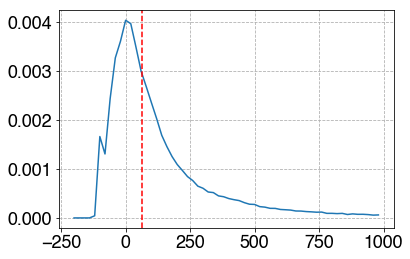

In [42]:
bins_percent = np.arange(-200, 1001, 20)
pdf_mcspcp_jja_wrf21_percent, bins = np.histogram(mcspcp_jja_wrf21_percent.sel(lon=slice(lonbox[0],lonbox[1]), lat=slice(latbox[0],latbox[1])), \
                                                  bins=bins_percent, density=True)
plt.plot(bins_percent[:-1], pdf_mcspcp_jja_wrf21_percent)
plt.axvline(mcspcp_jja_wrf21_cus_avg_percent, color='r', ls='--')
plt.grid(ls='--')

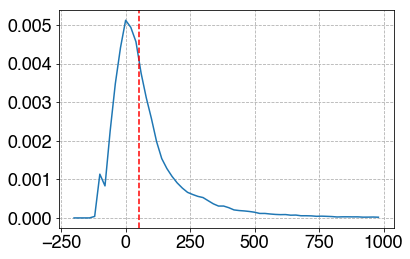

In [43]:
pdf_mcspcpfreq_jja_wrf21_percent, bins = np.histogram(mcspcpfreq_jja_wrf21_percent.sel(lon=slice(lonbox[0],lonbox[1]), lat=slice(latbox[0],latbox[1])), \
                                                      bins=bins_percent, density=True)
plt.plot(bins_percent[:-1], pdf_mcspcpfreq_jja_wrf21_percent)
plt.axvline(mcspcpfreq_jja_wrf21_cus_avg_percent, color='r', ls='--')
plt.grid(ls='--')

In [44]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

# Plot seasonal MCS rainmap difference

In [45]:
def plot_4map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata, plothist=False):

    mpl.rcParams['font.size'] = 18
    mpl.rcParams['font.family'] = 'Helvetica'
    map_extend = [-106.1, -76, 24.9, 48.1]
    cbshrink = 0.8
    lonv = list(np.arange(-115,-55.1,10))
    latv = list(np.arange(20,61,5))
    lonvals = mpl.ticker.FixedLocator(lonv)
    latvals = mpl.ticker.FixedLocator(latv)
    proj = ccrs.LambertConformal()
    states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', 
                                          scale='50m', facecolor='none')
    fig = plt.figure(figsize=[18,12], dpi=100)

    for pp in range(0,4):
        ax = plt.subplot(2, 2, pp+1, projection=proj)
        ax.set_extent(map_extend, crs=ccrs.Geodetic())
        ax.add_feature(cartopy.feature.LAND, facecolor='silver')
        ax.add_feature(cartopy.feature.OCEAN)
        ax.add_feature(cartopy.feature.LAKES)
        ax.add_feature(cartopy.feature.BORDERS, zorder=2)
        ax.coastlines(resolution='50m', zorder=2)
        ax.add_feature(states, linewidth=1, edgecolor='k', zorder=2)
        ax.set_aspect('auto', adjustable=None)
        
        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        # Label the end-points of the gridlines using the custom tick makers:
        ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
        if (pp >= 2):
            lambert_xticks(ax, lonv)
        if (pp == 0) | (pp == 2):
            lambert_yticks(ax, latv)

        cmap = plt.get_cmap(cmaps[pp])
        norm = mpl.colors.BoundaryNorm(levels[pp], ncolors=cmap.N, clip=True)
        Zm = np.ma.masked_where(((dataarr[pp] == 0) | (np.isnan(dataarr[pp]))), dataarr[pp])
        Zm = np.ma.masked_where(((landmask == 0)), Zm)
#         cf1 = plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
#         cf1 = plt.contourf(lon, lat, Zm, levels=levels[pp], norm=norm, cmap=cmap, extend='both', transform=ccrs.PlateCarree(), zorder=2)
        cf1 = plt.contourf(lon, lat, Zm, levels=levels[pp], cmap=cmap, extend='both', transform=ccrs.PlateCarree(), zorder=2)
        ax.set_title(titles[pp], loc='left')
        cb1 = plt.colorbar(cf1, label=cblabels[pp], pad=0.03, ticks=cbticks[pp], extend='both')

        # Plot box
#         b1 = ax.add_patch(mpl.patches.Rectangle(xy=[boxlatlon[0],boxlatlon[1]], width=boxlatlon[2], height=boxlatlon[3],
#                                       edgecolor='magenta', facecolor='None', lw=3, transform=ccrs.Geodetic()))
        x1 = np.arange(lonbox[0],lonbox[1]+0.1,1)
        y1 = np.repeat(latbox[0],len(x1))
        y2 = np.arange(latbox[0],latbox[1]+0.1,1)
        x2 = np.repeat(lonbox[1],len(y2))
        y3 = np.repeat(latbox[1],len(x1))
        x4 = np.repeat(lonbox[0],len(y2))
        xx = np.concatenate((x1,x2,x1[::-1],x4))
        yy = np.concatenate((y1,y2,y3,y2[::-1]))
        b1 = ax.plot(xx, yy, color='magenta', lw=3, transform=ccrs.Geodetic(), zorder=3)
        
        # Plot inset PDF
        if ((pp == 3) & (plothist == True)):
            fontsize_ax = 14
            fontcolor_ax = 'k'
#             ax.add_patch(mpl.patches.Rectangle(xy=[-108, 23], width=17, height=12, facecolor='white', alpha=0.8, transform=ccrs.PlateCarree()))
            axins = ax.inset_axes([0.12, 0.12, 0.4, 0.25])
            axins.set_facecolor('white')
            axins.patch.set_alpha(0.8)     
            axins.plot(histdata[0][:-1], histdata[1], color='magenta', lw=3)
            axins.axvline(histdata[2], color='g', lw=3)
            axins.annotate(f'Mean: {histdata[2]:.0f}%', xy=(histdata[2],3.5), xytext=(300,2.5), arrowprops=dict(facecolor='black', shrink=0.04), 
                           fontsize=fontsize_ax*1.5, fontweight='bold', color='g', ha='left', va='center')
            axins.grid(ls=':', lw=1.5, color='dimgray')
            axins.set_ylabel('PDF (x10$^{3}$)', fontsize=fontsize_ax, color=fontcolor_ax, fontweight='bold')
            axins.set_xlabel(cblabels[pp], fontsize=fontsize_ax, color=fontcolor_ax, fontweight='bold')
            axins.set_xticks(histdata[3])
            axins.tick_params(axis='both', which='major', labelsize=10, color='magenta', labelcolor=fontcolor_ax, zorder=10)
            for axis in ['top','bottom','left','right']:
                axins.spines[axis].set_linewidth(3)
            for tick in axins.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize_ax)
                tick.label1.set_fontweight('bold')
            for tick in axins.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize_ax)
                tick.label1.set_fontweight('bold')

    plt.tight_layout(h_pad=0.8, w_pad=0.2)
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    return fig

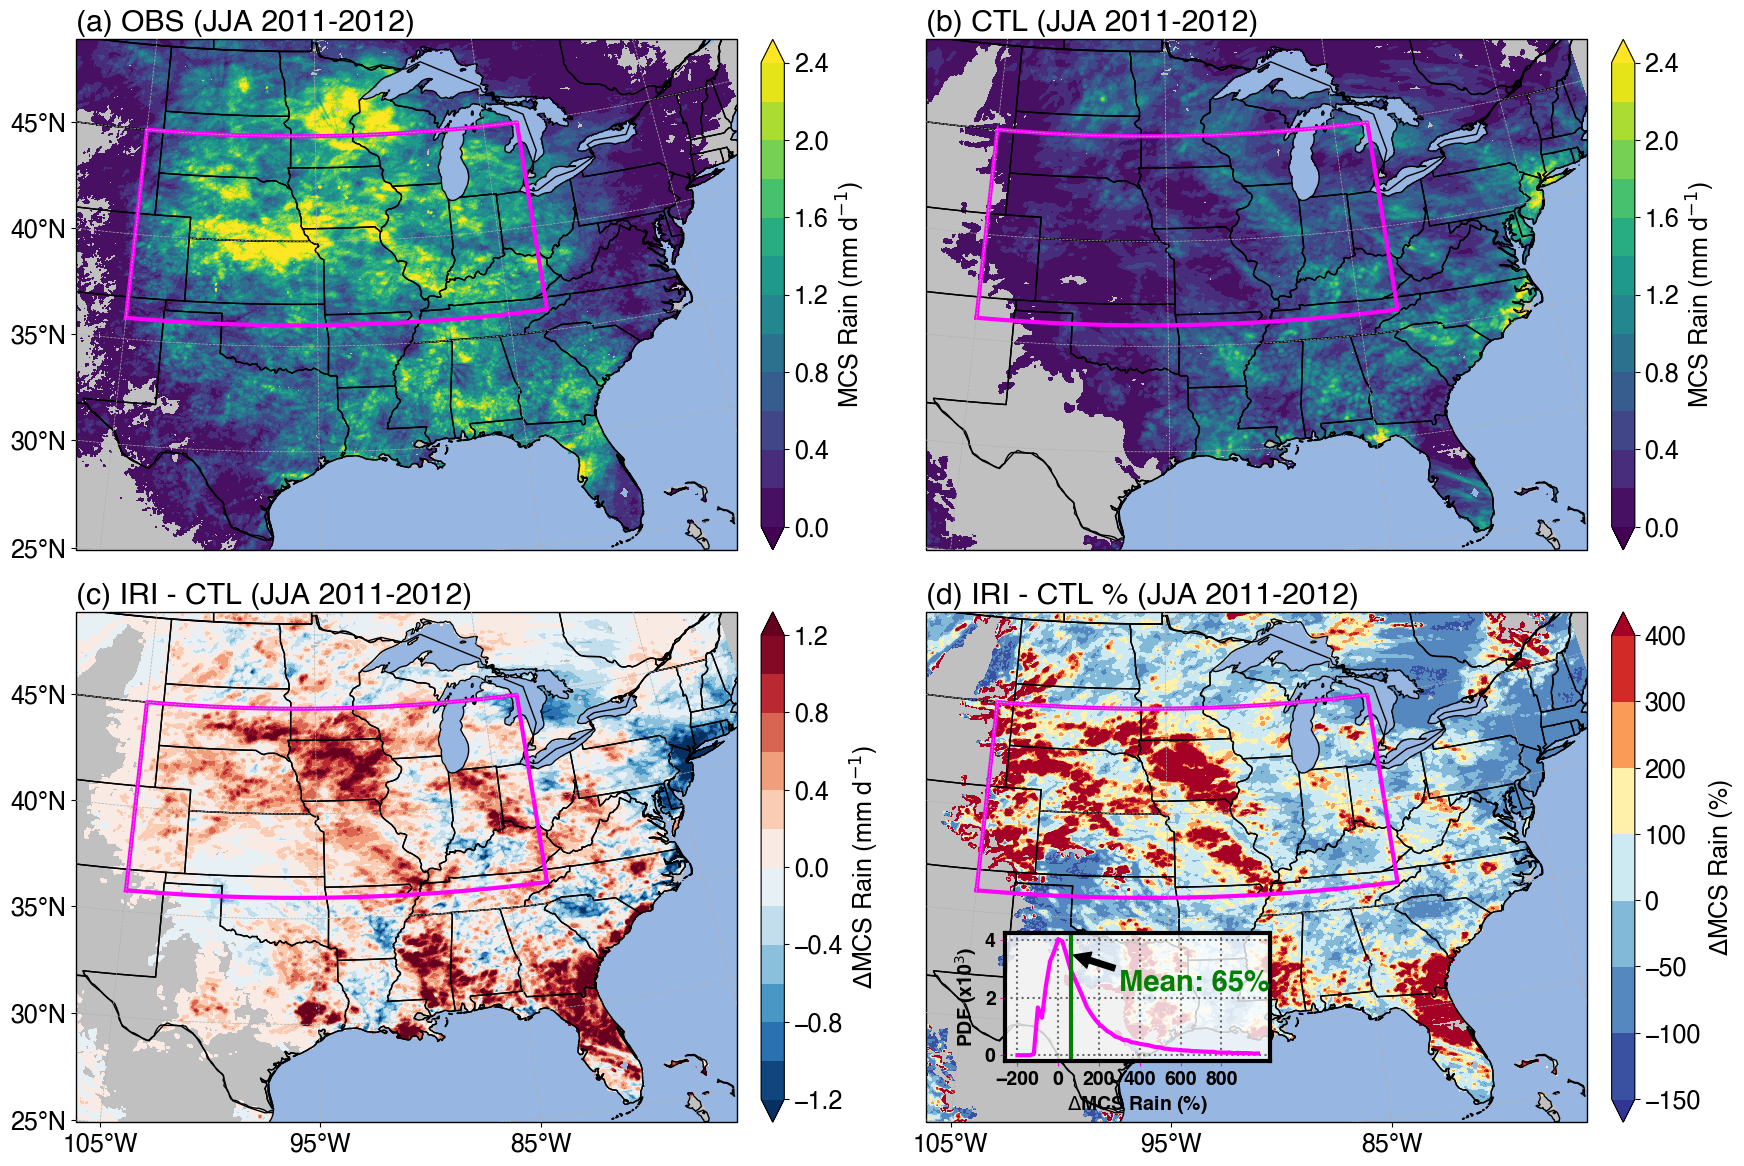

In [59]:
dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrf21, mcspcp_jja_wrf21_percent]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), np.arange(-300, 301, 100)]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), np.arange(-300, 301, 100)]
levdiff = np.arange(-1.2,1.21,0.2)
levper = [-150,-100,-50,0,100,200,300,400]
levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), levdiff, levper]
cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), np.arange(-1.2,1.21,0.4), levper]
cmaps = ['viridis','viridis','RdBu_r','RdYlBu_r']
titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL (JJA {year})', f'(d) IRI - CTL % (JJA {year})']
cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (%)']
figname = f'{figdir}obs_wrf_mcs_rainmap_diffpercent_mean_{year}jja.png'
# figname = f'{figdir}obs_wrf_mcs_rainmap_diffpercent_mean_{year}jja.pdf'
histxticks = np.arange(-200, 1000, 200)
bins_percent = np.arange(-200, 1001, 20)
histdata = [bins_percent, pdf_mcspcp_jja_wrf21_percent*1e3, mcspcp_jja_wrf21_cus_avg_percent, histxticks]
fig = plot_4map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata=histdata, plothist=True)

In [60]:
figname

'/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/obs_wrf_mcs_rainmap_diffpercent_mean_2011-2012jja.png'

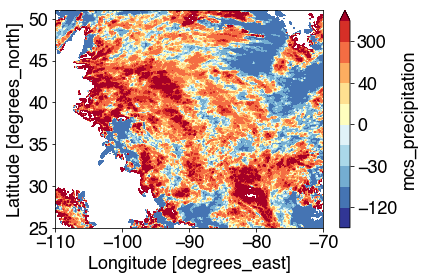

In [48]:
levper = [-200,-120,-60,-30,-10,0,20,40,100,300,600]
mcspcp_jja_wrf21_percent.plot.contourf(levels=levper, cmap='RdYlBu_r')

In [49]:
# dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrf21, mcspcp_jja_wrfobs_percent]
# levdiff = np.arange(-1.2,1.21,0.2)
# levper = [-200,-120,-60,-30,-10,0,20,40,100,300,600]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), levdiff, levper]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), np.arange(-1.2,1.21,0.4), levper]
# cmaps = ['viridis','viridis','RdBu_r','RdYlBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL (JJA {year})', f'(d) (IRI - CTL)/(OBS - CTL) % (JJA {year})']
# cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (%)']
# figname = f'{figdir}obs_wrf_mcs_rainmap_diffpercentobs_mean_{year}jja.png'
# histxticks = [-150,0,150,300]
# histdata = [bins_wrfobs, pdf_mcspcp_jja_wrfobs_percent*1e3, pdf_mcspcp_jja_wrfobs_cus_avg_percent, histxticks]
# fig = plot_4map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata=histdata, plothist=False)

In [50]:
# dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrfobs_percent]
# # levper = [-150,-100,-50,0,100,200,300,400]
# levper = [-200,-120,-60,-30,-10,0,20,40,100,300,600]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), levper]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), levper]
# cmaps = ['viridis','viridis','RdYlBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) (IRI - CTL)/(OBS - CTL) % (JJA {year})']
# cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (%)']
# figname = f'{figdir}obs_wrf_mcs_rainmappercentobs_mean_{year}jja.png'
# histxticks = [-150,0,150,300]

In [51]:
# def plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata, plothist=False):

#     mpl.rcParams['font.size'] = 15
#     mpl.rcParams['font.family'] = 'Helvetica'
#     map_extend = [-106.1, -76, 24.9, 48.1]
#     cbshrink = 0.8
#     lonv = list(np.arange(-115,-55.1,10))
#     latv = list(np.arange(20,61,5))
#     lonvals = mpl.ticker.FixedLocator(lonv)
#     latvals = mpl.ticker.FixedLocator(latv)
#     proj = ccrs.LambertConformal()
#     states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', 
#                                           scale='50m', facecolor='none')
#     fig = plt.figure(figsize=[21,5], dpi=100)

#     for pp in range(0,3):
#         ax = plt.subplot(1, 3, pp+1, projection=proj)
#         ax.set_extent(map_extend, crs=ccrs.Geodetic())
#         ax.add_feature(cartopy.feature.LAND, facecolor='silver')
#         ax.add_feature(cartopy.feature.OCEAN)
#         ax.add_feature(cartopy.feature.LAKES)
#         ax.add_feature(cartopy.feature.BORDERS, zorder=2)
#         ax.coastlines(resolution='50m', zorder=2)
#         ax.add_feature(states, linewidth=1, edgecolor='k', zorder=2)
#         ax.set_aspect('auto', adjustable=None)
        
#         # *must* call draw in order to get the axis boundary used to add ticks:
#         fig.canvas.draw()
#         gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
#         gl.xlabels_top = False
#         gl.ylabels_right = False
#         gl.xlocator = lonvals
#         gl.ylocator = latvals
#         # Label the end-points of the gridlines using the custom tick makers:
#         ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#         ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#         lambert_xticks(ax, lonv)
#         if (pp == 0):
#             lambert_yticks(ax, latv)

#         cmap = plt.get_cmap(cmaps[pp])
#         norm = mpl.colors.BoundaryNorm(levels[pp], ncolors=cmap.N, clip=True)
#         Zm = np.ma.masked_where(((dataarr[pp] == 0) | (np.isnan(dataarr[pp]))), dataarr[pp])
#         Zm = np.ma.masked_where(((landmask == 0)), Zm)
#         cf1 = plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
# #         cf1 = plt.contourf(lon, lat, Zm, levels=levels[pp], cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
#         ax.set_title(titles[pp], loc='left')
#         cb1 = plt.colorbar(cf1, label=cblabels[pp], pad=0.03, ticks=cbticks[pp], extend='both')

#         # Plot box
# #         b1 = ax.add_patch(mpl.patches.Rectangle(xy=[boxlatlon[0],boxlatlon[1]], width=boxlatlon[2], height=boxlatlon[3],
# #                                       edgecolor='magenta', facecolor='None', lw=3, transform=ccrs.Geodetic()))
#         x1 = np.arange(lonbox[0],lonbox[1]+0.1,1)
#         y1 = np.repeat(latbox[0],len(x1))
#         y2 = np.arange(latbox[0],latbox[1]+0.1,1)
#         x2 = np.repeat(lonbox[1],len(y2))
#         y3 = np.repeat(latbox[1],len(x1))
#         x4 = np.repeat(lonbox[0],len(y2))
#         xx = np.concatenate((x1,x2,x1[::-1],x4))
#         yy = np.concatenate((y1,y2,y3,y2[::-1]))
#         b1 = ax.plot(xx, yy, color='magenta', lw=3, transform=ccrs.Geodetic(), zorder=3)
        
#         # Plot inset PDF
#         if ((pp == 2) & (plothist == True)):
#             fontsize_ax = 10
#             fontcolor_ax = 'magenta'
#             axins = ax.inset_axes([0.12, 0.12, 0.35, 0.25])
#             axins.patch.set_alpha(0.3)
#             axins.plot(histdata[0][:-1], histdata[1], color='magenta', lw=2)
#             axins.axvline(histdata[2], color='r', ls='--')
#             axins.grid(ls=':', lw=1.5, color='dimgray')
#             axins.set_ylabel('PDF (x10$^{3}$)', fontsize=fontsize_ax, color=fontcolor_ax, fontweight='bold')
#             axins.set_xlabel(cblabels[pp], fontsize=fontsize_ax, color=fontcolor_ax, fontweight='bold')
#             axins.set_xticks(histdata[3])
#             axins.tick_params(axis='both', which='major', labelsize=10, color='magenta', labelcolor=fontcolor_ax, zorder=10)
#             for axis in ['top','bottom','left','right']:
#                 axins.spines[axis].set_linewidth(2)
#             for tick in axins.xaxis.get_major_ticks():
#                 tick.label1.set_fontsize(fontsize_ax)
#                 tick.label1.set_fontweight('bold')
#             for tick in axins.yaxis.get_major_ticks():
#                 tick.label1.set_fontsize(fontsize_ax)
#                 tick.label1.set_fontweight('bold')

#     plt.tight_layout(h_pad=0.8, w_pad=0.2)
#     fig.savefig(figname, dpi=300, bbox_inches='tight')
#     return fig

In [52]:
# dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrf21_percent]
# # levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), np.arange(-300, 301, 100)]
# # cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), np.arange(-300, 301, 100)]
# levper = [-150,-100,-50,0,100,200,300,400]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), levper]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), levper]
# cmaps = ['viridis','viridis','RdYlBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL % (JJA {year})']
# cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (%)']
# figname = f'{figdir}obs_wrf_mcs_rainmappercent_mean_{year}jja.png'
# histxticks = np.arange(-200, 1000, 200)
# histdata = [bins_percent, pdf_mcspcp_jja_wrf21_percent*1e3, mcspcp_jja_wrf21_cus_avg_percent, histxticks]
# fig = plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata=histdata, plothist=True)

In [53]:
# dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrfobs_percent]
# # levper = [-150,-100,-50,0,100,200,300,400]
# levper = [-200,-120,-60,-30,-10,0,20,40,100,300,600]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), levper]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), levper]
# cmaps = ['viridis','viridis','RdYlBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) (IRI - CTL)/(OBS - CTL) % (JJA {year})']
# cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (%)']
# figname = f'{figdir}obs_wrf_mcs_rainmappercentobs_mean_{year}jja.png'
# histxticks = [-150,0,150,300]
# histdata = [bins_wrfobs, pdf_mcspcp_jja_wrfobs_percent*1e3, pdf_mcspcp_jja_wrfobs_cus_avg_percent, histxticks]
# fig = plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname, histdata=histdata, plothist=True)

In [54]:
# # levels = np.arange(-400, 401, 100)
# levels = [-150,-100,-50,0,100,200,300,400]
# cmap = plt.get_cmap('RdYlBu_r')
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# plt.pcolormesh(lon, lat, mcspcp_jja_wrf21_percent, norm=norm, cmap=cmap)
# # plt.contourf(lon, lat, mcspcp_jja_wrf21_percent, levels=levels, cmap=cmap, extend='both')
# plt.colorbar()

In [55]:
# dataarr = [mcspcp_jja_obs, mcspcp_jja_wrf1, mcspcp_jja_wrf21]
# levels = [np.arange(0, 2.41, 0.2), np.arange(0, 2.41, 0.2), np.arange(-1.2, 1.21, 0.2)]
# cbticks = [np.arange(0, 2.41, 0.4), np.arange(0, 2.41, 0.4), np.arange(-1.2, 1.21, 0.4)]
# # lonbox = [-105,-83]
# # latbox = [36,45]
# cmaps = ['viridis','viridis','RdBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL (JJA {year})']
# cblabels = ['MCS Rain (mm d$^{-1}$)','MCS Rain (mm d$^{-1}$)','$\Delta$MCS Rain (mm d$^{-1}$)']
# figname = f'{figdir}obs_wrf_mcs_rainmap_mean_{year}jja.png'
# fig = plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname)

In [56]:
# dataarr = [mcspcpfreq_jja_obs, mcspcpfreq_jja_wrf1, mcspcpfreq_jja_wrf21]
# levels = [np.arange(0, 1.41, 0.2), np.arange(0, 1.41, 0.2), np.arange(-0.8, 0.81, 0.1)]
# cbticks = [np.arange(0, 1.41, 0.2), np.arange(0, 1.41, 0.2), np.arange(-0.8, 0.81, 0.2)]
# cmaps = ['viridis','viridis','RdBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL (JJA {year})']
# cblabels = ['MCS Rain Freq (%)','MCS Rain Freq (%)','$\Delta$MCS Rain Freq (%)']
# figname = f'{figdir}obs_wrf_mcs_rainfreqmap_mean_{year}jja.png'
# fig = plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname)

In [57]:
# dataarr = [totpcp_jja_obs, totpcp_jja_wrf1, totpcp_jja_wrf21]
# levels = [np.arange(0, 5.01, 0.5), np.arange(0, 5.01, 0.5), np.arange(-3, 3.1, 0.5)]
# cbticks = [np.arange(0, 5.01, 1), np.arange(0, 5.01, 1), np.arange(-3, 3.1, 1)]
# cmaps = ['viridis','viridis','RdBu_r']
# titles = [f'(a) OBS (JJA {year})', f'(b) CTL (JJA {year})', f'(c) IRI - CTL (JJA {year})']
# cblabels = ['Total Rain (mm d$^{-1}$)','Total Rain (mm d$^{-1}$)','$\Delta$Total Rain (mm d$^{-1}$)']
# figname = f'{figdir}obs_wrf_total_rainmap_mean_{year}jja.png'
# fig = plot_map_season(dataarr, lonbox, latbox, levels, cmaps, titles, cblabels, cbticks, figname)

In [58]:
figdir

'/project/projectdirs/m1660/www/yang560/IRI_MCS/fig1/'